In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import chess_cv.utils as utils
from scipy.linalg import qr
%matplotlib inline

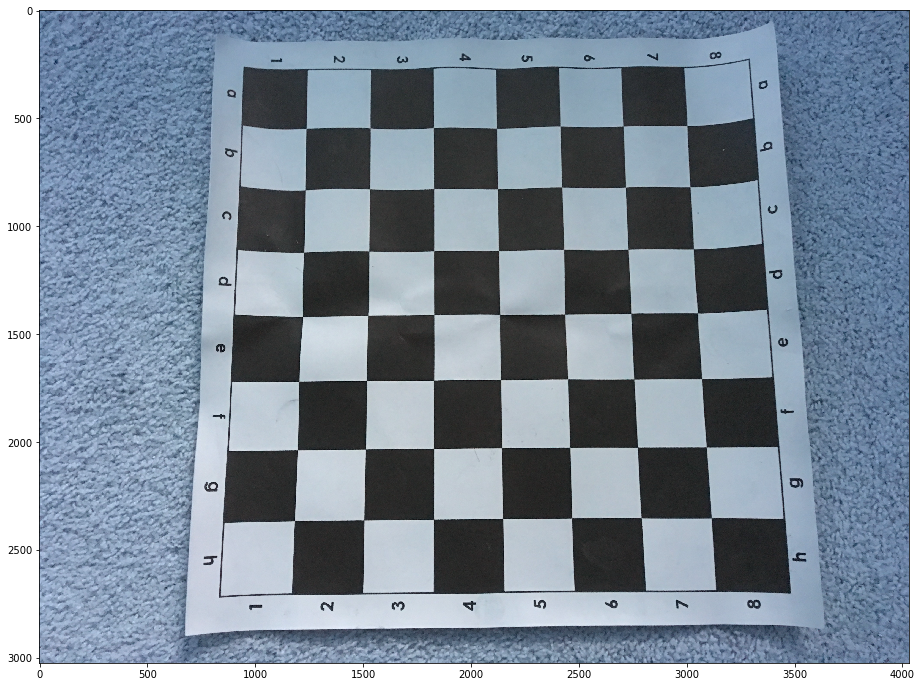

In [4]:
#img_bgr = cv2.imread('data/one_corner.JPG') # works
# img_bgr = cv2.imread('data/IMG_0650.JPG') # works
img_bgr = cv2.imread('data/IMG_0649.JPG') # works

#img_bgr = cv2.imread('data/IMG_0648.JPG') # works with sqrt y calc and bad line filtering
#img_bgr = cv2.imread('data/IMG_0651.JPG') # works with sqrt y calc and bad line filtering
def rotateImage(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result
# img_bgr = rotateImage(img_bgr, 45)
utils.imshow_lg(plt, img_bgr)

In [20]:
gray = utils.bgr2gray(img_bgr)
rows, cols = gray.shape

gray = cv2.pyrDown(gray, dstsize=(cols//2, rows//2))
rows, cols = rows//2, cols//2
gray = cv2.pyrDown(gray, dstsize=(cols//2, rows//2))
rows, cols = rows//2, cols//2

assert (rows, cols) == gray.shape

def rect (img, pts, color=(0, 0, 255), size=5):
    first, last = pts[0], pts[0]
    for pt in pts[1:]:
        img = cv2.line(img, last,pt,color,size)
        last = pt
    return cv2.line(img,last,first,color,size)

In [43]:
def solve_minnonzero(A, b):
    x1, res, rnk, s = np.linalg.lstsq(A, b)
    if rnk == A.shape[1]:
        return x1   # nothing more to do if A is full-rank
    Q, R, P = qr(A.T, mode='full', pivoting=True)
    Z = Q[:, rnk:].conj()
    C = np.linalg.solve(Z[rnk:], -x1[rnk:])
    return x1 + Z.dot(C)

def hessian(x):
    """
    Calculate the hessian matrix with finite differences
    Parameters:
       - x : ndarray
    Returns:
       an array of shape (x.dim, x.ndim) + x.shape
       where the array[i, j, ...] corresponds to the second derivative x_ij
    """
    x_grad = np.gradient(x) 
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype=x.dtype) 
    for k, grad_k in enumerate(x_grad):
        # iterate over dimensions
        # apply gradient again to every component of the first derivative.
        tmp_grad = np.gradient(grad_k) 
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
    return hessian

def find_saddle(img):
    m, n = img.shape
    bimg = cv2.GaussianBlur(img, (35,35), 8)
#     bimg = img
    X = np.zeros((m*n, 6), dtype=np.double)
    intensities = np.zeros((m*n, 1), dtype=np.double)
    i = 0
    for y in range(m):
        for x in range(n):
            X[i,:] = np.array([x**2, y**2, 2*x*y, y, x, 1])
            intensities[i] = bimg[y, x] / 255
            i = i + 1
    
    theta = np.linalg.pinv(X) @ intensities
    #theta = (np.linalg.pinv(Xt @ X) @ Xt) @ intensities
    
    A = np.array([theta[0], theta[2], theta[2],theta[1]]).reshape((2,2))
    b = np.array([theta[4], theta[3]]).reshape((2,1))
    
    w, v = np.linalg.eig(A)
#     print('w:')
    #print(np.linalg.norm(w))
    #np.any(np.isclose(w, np.zeros(w.shape), atol=1e-3)) or 
    if (w[0] < 0 and w[1] < 0) or (w[0] > 0 and w[1] > 0):
        return None
    return np.linalg.solve(2*A, -b), np.linalg.norm(w)

In [51]:
patch_size = 101
ps = patch_size # brevity
saddle_points = []
for i in range(0, rows - ps, ps // 2):
    for j in range(0, cols - ps, ps // 2):
        patch = gray[i:i+ps,j:j+ps]
        pt = find_saddle(patch)
        if pt is None:
            continue
        pt, norm = pt
        if pt[0] > ps or pt[1] > ps:
#             print(f'point {pt} is outside patch')
            continue
        if norm < .00011:
            continue
#         print(f'pt: {pt}')
#         print(f'pt norm: {np.linalg.norm(pt)}')
        saddle_points.append([j + pt[0], i + pt[1]])
        

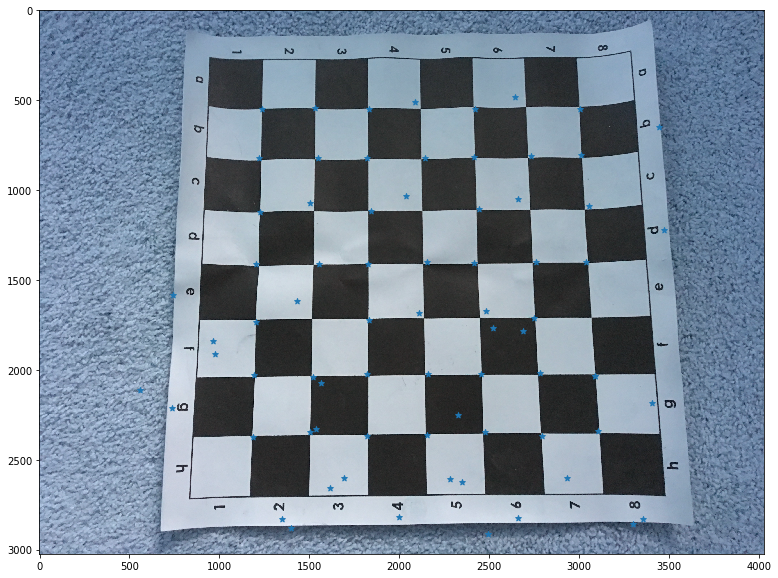

In [52]:
points = np.array(saddle_points).reshape((len(saddle_points), 2)) * 4
plt.figure(figsize=(20,10))
plt.imshow(img_bgr)
plt.scatter(points[:, 0], points[:, 1], marker='*')